In [5]:
import torch
#import matplotlib as mpl
from torch import nn, optim
from torch.utils.data import TensorDataset, random_split, DataLoader
from matplotlib import pyplot as plt

# Create dataset
N = 5000  # Number of samples
x = torch.randn(N, 3)  # 3D Gaussian (normal) distribution
y = x / torch.norm(x, dim=1, keepdim=True)  # Project to unit sphere

# Split data
dataset = TensorDataset(x, y)
train_size = int(0.7 * N)  # 70% train
val_size = int(0.15 * N)  # 15% validation
test_size = N - train_size - val_size  # 15% test

train_data, val_data, test_data = random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

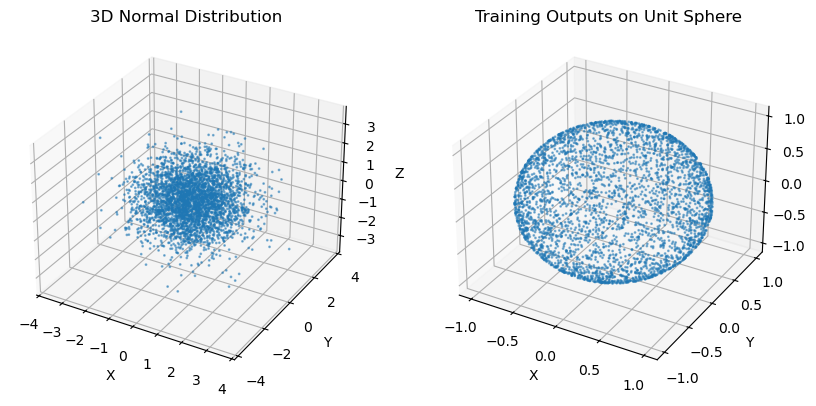

In [6]:
# 3D plot of training targets
fig = plt.figure(figsize=(10, 10))
def plot_sphere(location, data, title):
    ax = fig.add_subplot(location, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=1, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


# 3D normal distribution (input x)
x = x[train_data.indices]  # Limit display with [:500]
plot_sphere(121, x, "3D Normal Distribution")
# fig = plt.figure(figsize=(10, 10))
# ax1 = fig.add_subplot(121, projection='3d')
# ax1.scatter(x[:, 0], x[:, 1], x[:, 2], s=1, alpha=0.5)
# ax1.set_title("3D Gaussian Splatter")
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')


# Training targets (output y)
y = y[train_data.indices] 
plot_sphere(122, y, "Training Outputs on Unit Sphere")
# ax2 = fig.add_subplot(122, projection='3d')
# ax2.scatter(y[:, 0], y[:, 1], y[:, 2], s=1, alpha=0.5)
# ax2.set_title("Training Targets on Unit Sphere")
# ax2.set_xlabel('X')
# ax2.set_ylabel('Y')
# ax2.set_zlabel('Z')

plt.show()

In [7]:
# Create neural network
class SphereProjector(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 20),
            nn.LeakyReLU(0.01),
            nn.Linear(20, 20),
            nn.LeakyReLU(0.01),
            nn.Linear(20, 3)  # No activation for output layer (linear)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x)

model = SphereProjector()

# Loss and optimiser
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

# Early stopping setup
best_val_loss = float('inf')
patience = 10
counter = 0
train_losses = []
val_losses = []

In [8]:
# print(f"torch=={torch.__version__}")
# print(f"matplotlib=={mpl.__version__}")